In [19]:
import pickle
with open('./embedding_models/bitcoin_1.pkl', 'rb') as fr:
    data = pickle.load(fr)
    bitcoin_embeddings = data['embeddings']

## 输入文本，输出模型预测的向量的函数 

In [20]:
def calculate_vector(text):
    words = pre_process(text)
    vector = model.infer_vector(words, alpha=0.025, steps=500)
    return vector

## 计算余弦相似度的函数 

In [21]:
import numpy as np
def cos_sim(vector_a, vector_b):
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

In [22]:
with open('./embedding_models/sohu_by_bitcoin_1.pkl', 'rb') as fr:
    data = pickle.load(fr)
    sohu_by_bitcoin_embeddings = data['embeddings']

## 按文章介绍的流程，统计指定主题/随机主题的余弦相似度分布 

In [23]:
sims = []
for s in sohu_by_bitcoin_embeddings:
    vector_a = sohu_by_bitcoin_embeddings[str(s)]
    tmp = []
    for b in bitcoin_embeddings:
        vector_b = bitcoin_embeddings[str(b)]
        sim = cos_sim(vector_a, vector_b)
        tmp.append(sim)
    sims.append(np.mean(tmp))

In [24]:
sims_ = []
for s in bitcoin_embeddings:
    vector_a = bitcoin_embeddings[str(s)]
    tmp = []
    for b in bitcoin_embeddings:
        vector_b = bitcoin_embeddings[str(b)]
        sim = cos_sim(vector_a, vector_b)
        tmp.append(sim)
    sims_.append(np.mean(tmp))


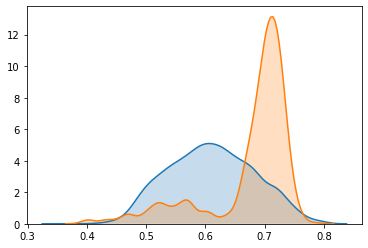

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(sims, shade=True)
sns.kdeplot(sims_, shade=True)
plt.savefig("cos.png", dpi=300)
plt.show()

## 显著性检验 

In [14]:
mean_sim = np.mean(sims)
std_sim = np.std(sims, ddof=1)
mean_sim, std_sim

(0.5071341999743249, 0.01200840075595868)

In [23]:
import jieba.posseg as psg
def pre_process(t):
    stopwords = [line.strip() for line in open('stopwords.txt',encoding='UTF-8').readlines()]
    alowed_flags = ['n','nz','v','t', 'ns', 'LOC', 'an', 'ORG', 'nw', 'vn']
    t_cut = psg.cut(t)
    t_cut = [ word for word, flag in t_cut if flag in alowed_flags ]
    t_cut = list(set(t_cut))
    t_split = " ".join(t_cut).split(" ")
    res = [ word for word in t_split if word not in stopwords ]
    return res
def significance(text, mean_sim=0.5071341999743249, std_sim=0.01200840075595868):
    data = pre_process(text)
    vector_a = model.infer_vector(data, alpha=0.025, steps=500)
    tmp = []
    for b in bitcoin_embeddings:
        vector_b = bitcoin_embeddings[str(b)]
        sim = cos_sim(vector_a, vector_b)
        tmp.append(sim)
    mean = np.mean(tmp)
    res = (mean-mean_sim)/std_sim
    return res

In [25]:
res_1 = significance("要深入剖析比特币的真相，我们需要对金融诈骗，有一个深入的认识")
res_2 = significance("三文鱼案板和地漏阳性 可能表明处理的海鲜样本有病毒，这个病毒的来源有两种可能性")
res_1, res_2

(0.5671711536779535, -1.482589918355635)

## 尝试用PCA和TSNE做降维可视化 

In [35]:
X = []
Y = []
for b in bitcoin_embeddings:
    X.append(bitcoin_embeddings[b])
    Y.append(1)
for s in sohu_by_bitcoin_embeddings:
    X.append(sohu_by_bitcoin_embeddings[s])
    Y.append(0)
X, Y = np.array(X), np.array(Y)

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [30]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

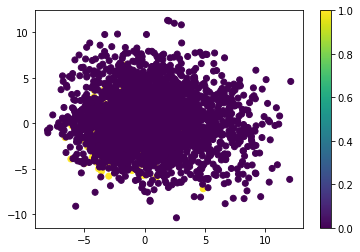

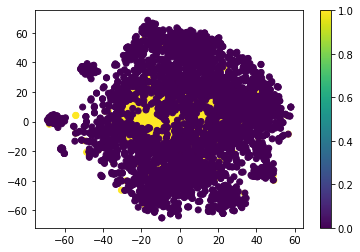

In [36]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=Y)
plt.colorbar()
plt.savefig("pca.jpg", dpi=300)
plt.show()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=Y)
plt.colorbar()
plt.savefig("tsne.jpg", dpi=300)
plt.show()